In [1]:
from datetime import datetime, timedelta, timezone
import pandas as pd
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import json
import matplotlib.pyplot as plt

In [2]:
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
from dataclasses import dataclass
import ta
import pandas as pd
import numpy as np

@dataclass
class MyStrategySettings:
    position_size: float = 0.25
    trailing_stop: float = 0.01

class MyStrategy(Strategy):
    def __init__(self, settings: MyStrategySettings):
        super().__init__()
        self.settings = settings

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()
        
        cci_upper_threshold = 100
        cci_lower_threshold = -100

        data['cci'] = ta.trend.cci(data['high'], data['low'], data['close'], window=20)
        data['cci_buy'] = data['cci'] < cci_lower_threshold
        data['cci_sell'] = data['cci'] > cci_upper_threshold

        data['macd'] = ta.trend.macd(data['close'], window_fast=12, window_slow=26)
        data['macdsignal'] = ta.trend.macd_signal(data['close'], window_fast=12, window_slow=26, window_sign=9)
        data['macdhist'] = ta.trend.macd_diff(data['close'], window_fast=12, window_slow=26, window_sign=9)
        data['macdhist_last'] = data['macdhist'].shift(1)
        data['macdhist_last2'] = data['macdhist'].shift(2)
        data['macd_buy'] = (data['macdhist'] > data['macdhist_last']) & (data['macdhist_last'] > data['macdhist_last2'])
        data['macd_sell'] = (data['macdhist'] < data['macdhist_last']) & (data['macdhist_last'] < data['macdhist_last2'])

        # Define entry points based on CCI and MACD
        data['long_entry'] = (data['cci_buy']) & (data['macd_buy'])
        
        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, self.settings.position_size, self.settings.trailing_stop)
        
        # No need to implement exit logic as we're using trailing stop loss


In [3]:
# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

SYMBOL = "BTC-GBP"
#SYMBOL = "AAPL"
train_since = pd.to_datetime('2024-03-11').tz_localize('UTC')
start_date = pd.to_datetime('2024-04-11').tz_localize('UTC')
end_date = pd.to_datetime('2024-05-11').tz_localize('UTC')
period = 168

feed = YFinanceFeed(interval = '1h')

settings = MyStrategySettings()
strategy = MyStrategy(settings)

# Create a Trader instance with the strategy
trader = Trader(SYMBOL, 1000, feed, strategy)

In [4]:
# Run the backtest
portfolio = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)

Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 25.0% of the cash (£250.0) and 1.0% trail
    Creating MARKET BUY order for BTC-GBP at 55834.453125 with quantity 0.004459612050691147, trail 0.01, limit None, stop None
    Executing MARKET BUY order for BTC-GBP at 55834.453125 with quantity 0.004459612050691147, total cost £249.996 and transaction cost £0.996
        Bought 0.004459612050691147 BTC-GBP at 55834.453125 on 11/04/2024 18:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 55834.453125 with quantity 0.004459612050691147, trail 0.01, limit None, stop 55276.10859375
    Updated trailing stop to 55455.2869921875
    Updated trailing stop to 55606.5094921875
    Updated trailing stop to 55706.3525390625
    Updated trailing stop to 56017.9163671875
    Updated trailing stop to 56171.34703125
    Updated trailing stop to 56183.621484375
    Updated trailing stop to 56288.932734375
    Executing TRAILING_STOP SELL order for BTC-GBP at 5

Win Rate: 0.40
Initial Value: 1000.00
Final Value: 971.88
Total Return: -0.0281


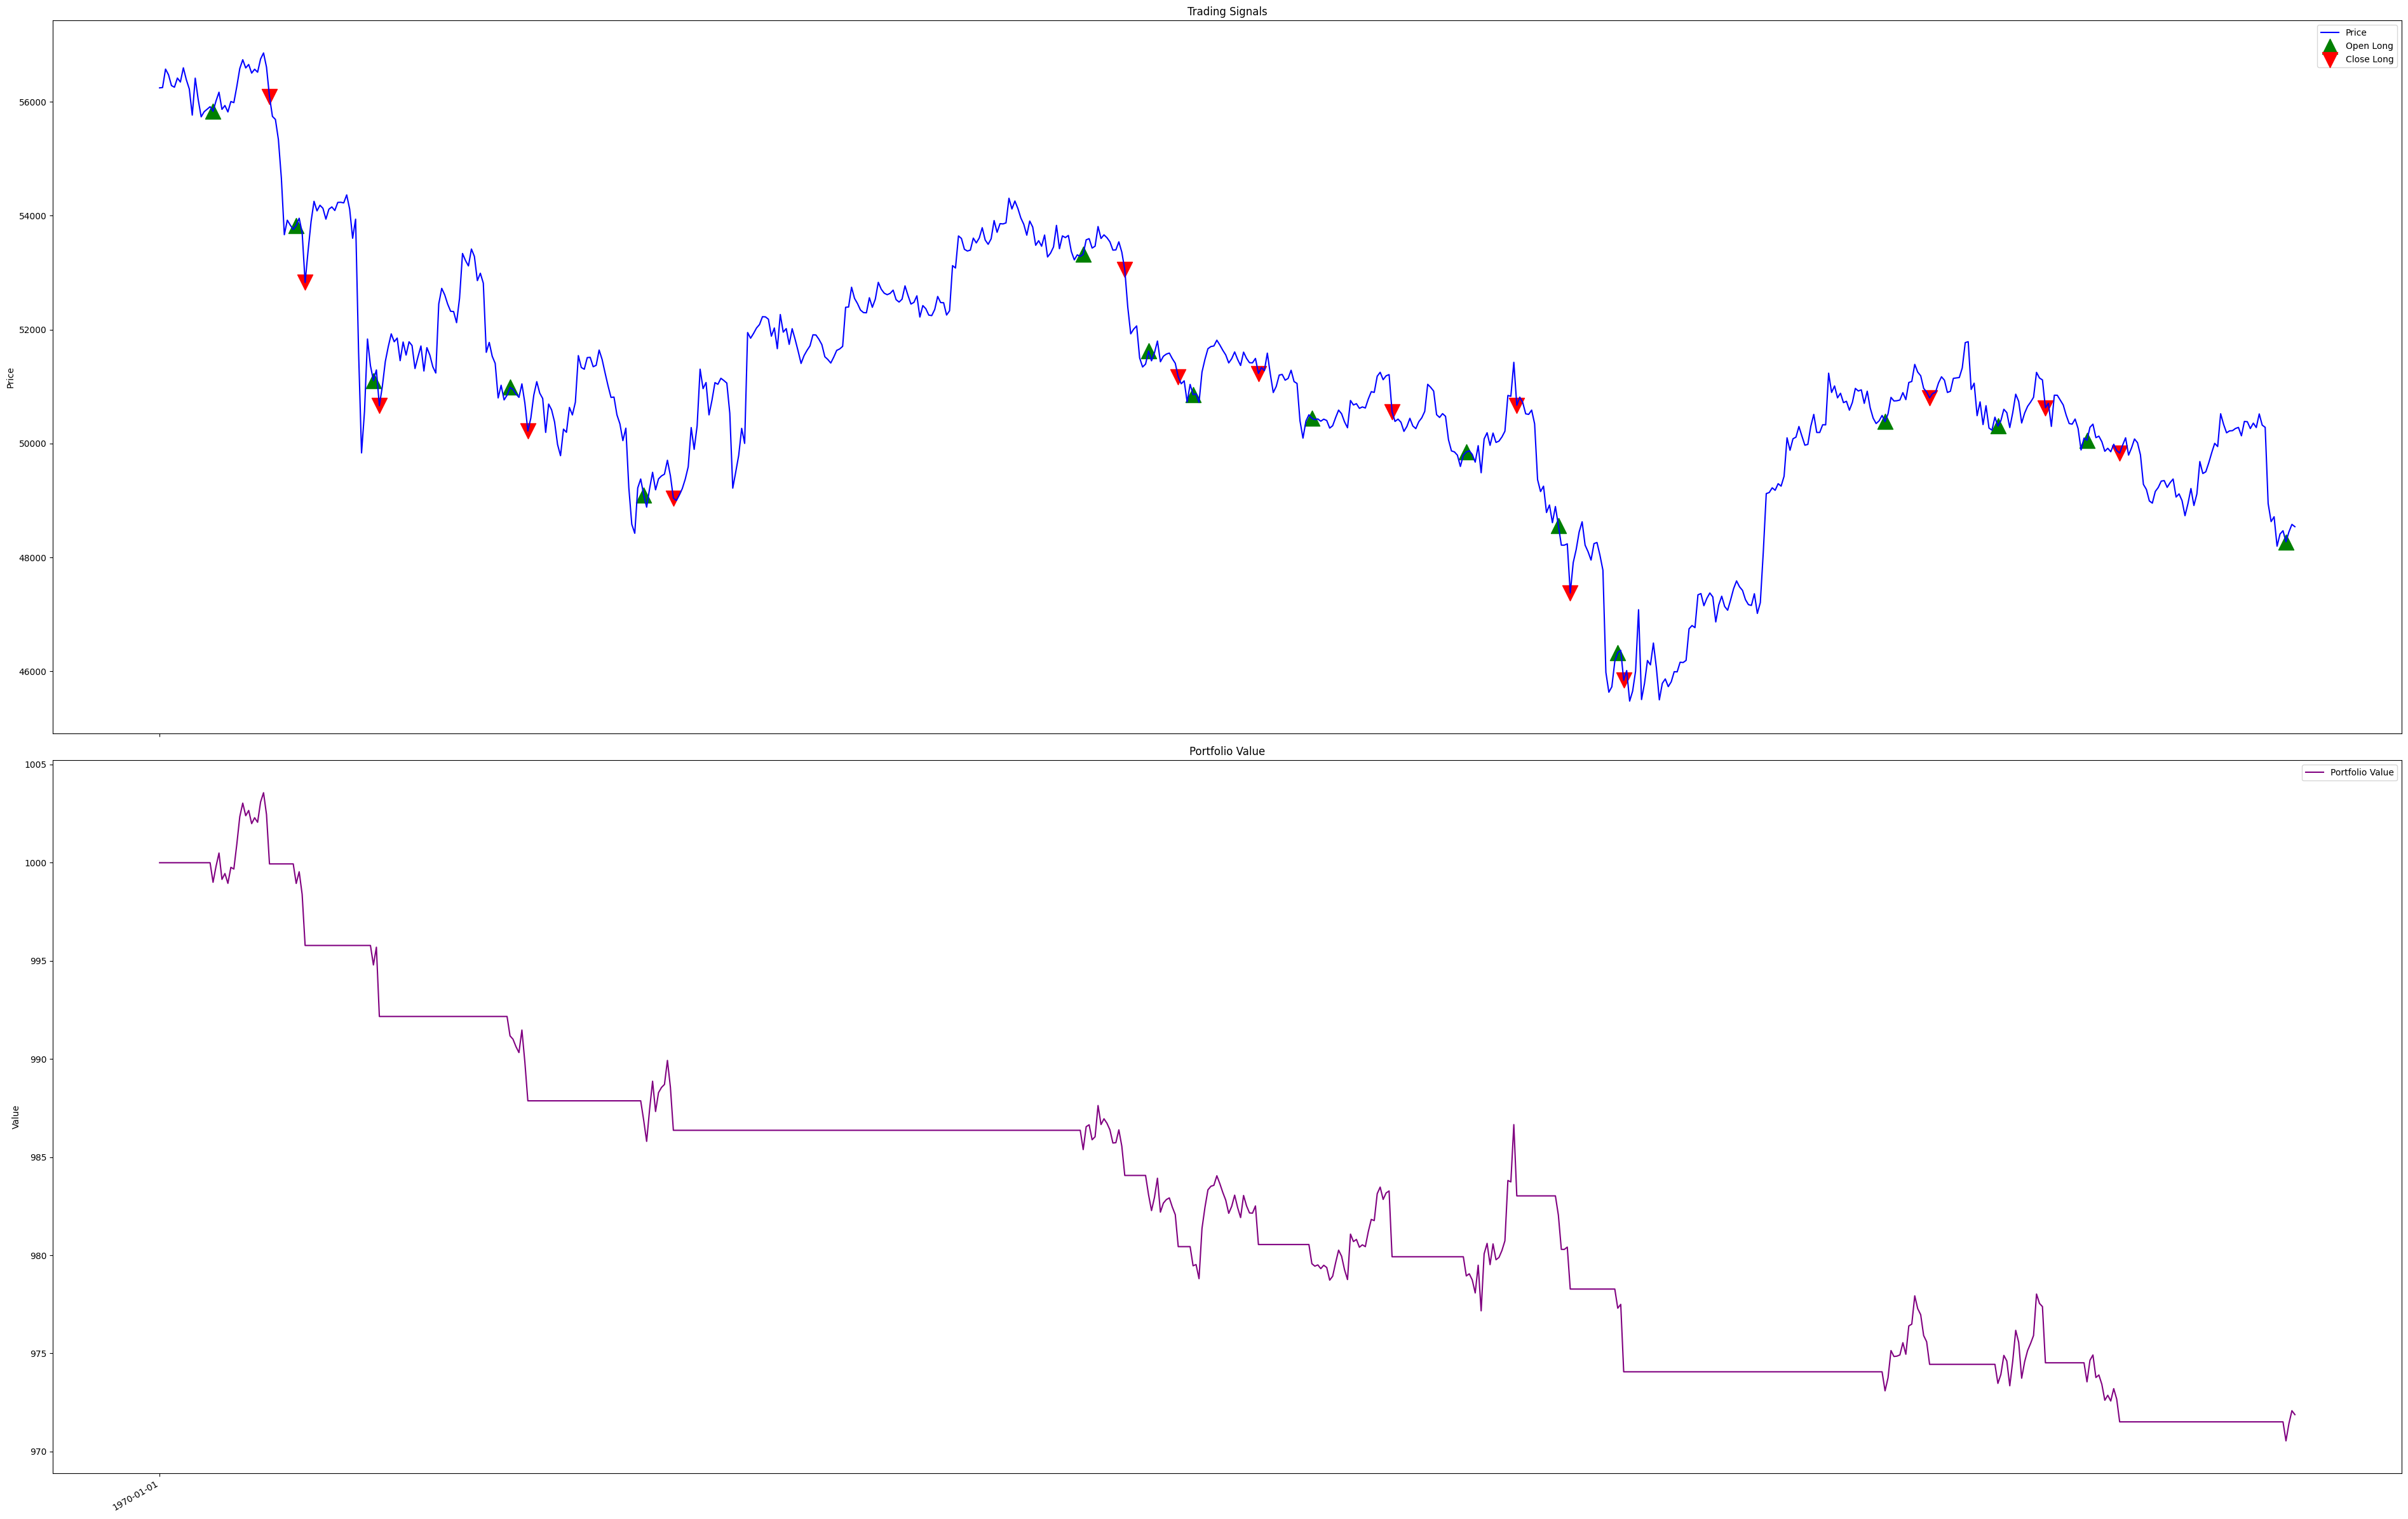

In [5]:
portfolio.plot_performance()